<a href="https://colab.research.google.com/github/priyanshi-nigam123/Brain_Tumor_Detection/blob/main/Brain_Tumor_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
#connecting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
#import libraries and tools
import os
import numpy as np
import random
from PIL import Image, ImageEnhance

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam
from PIL import ImageOps
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle

In [11]:
#load datasetes
train_dir = '/content/drive/MyDrive/dataset for BT ml/Training'
test_dir = '/content/drive/MyDrive/dataset for BT ml/Testing'

train_paths = []  #to store images
train_labels = [] #to store all labels

for label in os.listdir(train_dir):
  for image in os.listdir(os.path.join(train_dir, label)):
    train_paths.append(os.path.join(train_dir, label, image))
    train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

test_paths = []  #to store images
test_labels = [] #to store all labels

for label in os.listdir(test_dir):
  for image in os.listdir(os.path.join(test_dir, label)):
    test_paths.append(os.path.join(test_dir, label, image))
    test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

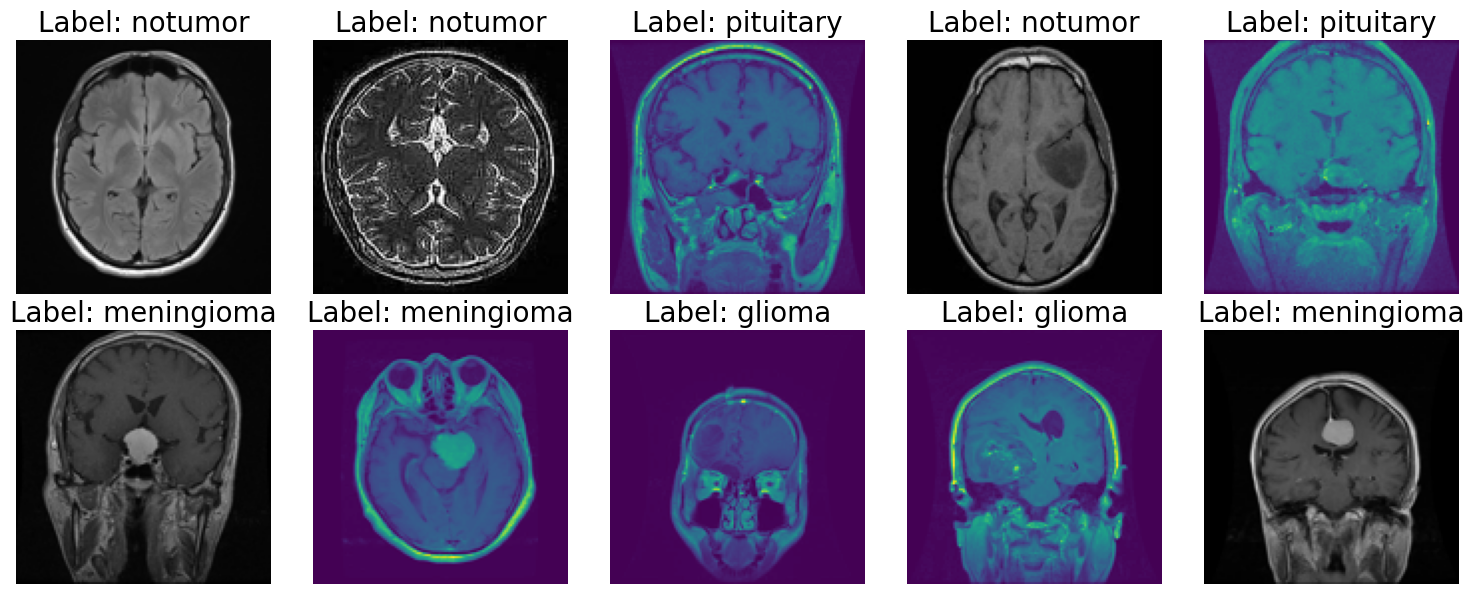

In [12]:
#data visualiszation
#selecting random images
import matplotlib.pyplot as plt
random_indices = random.sample(range(len(train_paths)),10)

#displaying images in 2 rows, creating figure
fig, axes = plt.subplots(2, 5, figsize=(15,6))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
  img_path = train_paths[idx]
  img = Image.open(img_path)
  img = img.resize((128,128))
  axes[i].imshow(img)
  axes[i].axis('off')
  axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=20)
plt.tight_layout()
plt.show()

In [13]:
#image preprocessing

def augment_image(image):
  image = Image.fromarray(np.uint8(image))
  image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
  image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
  image = ImageEnhance.Sharpness(image).enhance(random.uniform(0.8, 1.2))
  image = np.array(image)/255.0
  return image

def open_images(paths):
  images =[]
  for path in paths:
    img = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img = augment_image(img)
    images.append(img)
  return np.array(images)

def encode_label(labels):
  unique_labels = os.listdir(train_dir)
  encoded = [unique_labels.index(label) for label in labels]
  return encoded

def data_gen(paths, labels, batch_size=12, epochs=1):
  while True:
    for i in range(0, len(paths), batch_size):
      batch_paths = paths[i:i+batch_size]
      batch_images = open_images(batch_paths)
      batch_labels = encode_label(labels[i:i+batch_size])
      yield batch_images, np.array(batch_labels)

In [ ]:
#model architecture
IMAGE_SIZE = 128
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')
for layer in base_model.layers:
  layer.trainable = False

base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model  = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(len(os.listdir(train_dir)), activation = 'softmax'))

model.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])

batch_size = 20
steps = int(len(train_paths)/ batch_size)
epochs = 10

history = model.fit(
    data_gen(train_paths, train_labels, batch_size = batch_size, epochs = 1),
    steps_per_epoch = steps,
    epochs = epochs,
    validation_data=data_gen(test_paths, test_labels, batch_size=batch_size),
    validation_steps=int(len(test_paths)/batch_size)
    )

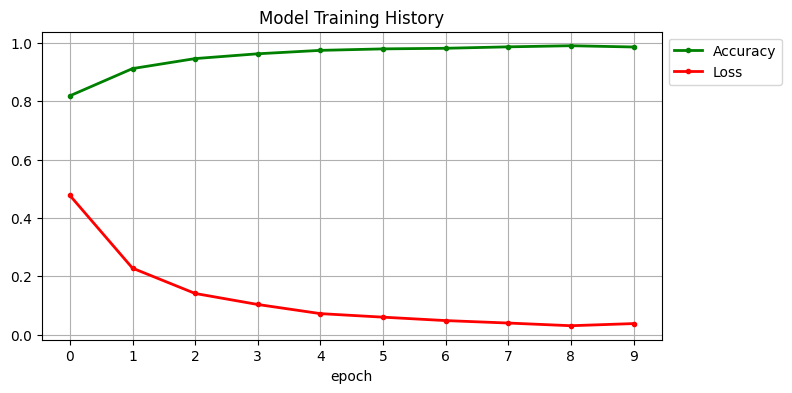

In [16]:
#graph
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth = 2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize

test_images = open_images(test_paths)
test_labels_encoded = encode_label(test_labels)

test_predictions = model.predict(test_images)

print("Classification Report")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))


42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.79      0.96      0.87       313
           1       0.91      0.91      0.91       405
           2       0.65      0.66      0.65       306
           3       0.93      0.70      0.80       300

    accuracy                           0.82      1324
   macro avg       0.82      0.81      0.81      1324
weighted avg       0.82      0.82      0.82      1324



Confusion Matrix:
[[301   2   7   3]
 [  7 368  24   6]
 [ 61  36 202   7]
 [ 10   0  80 210]]


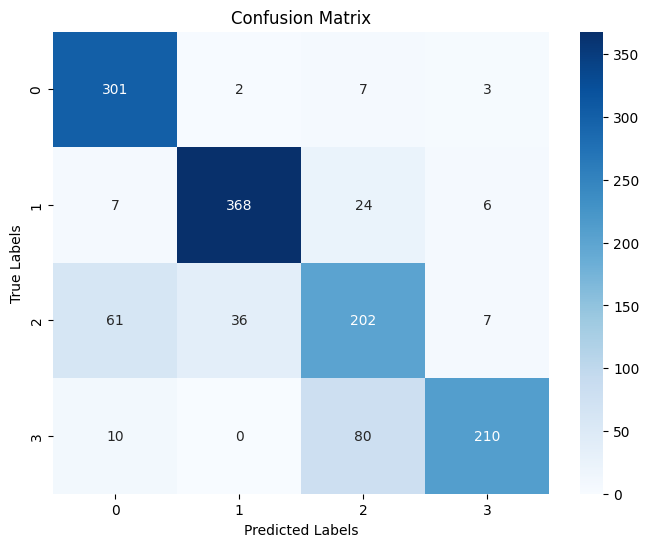

In [18]:
#confusion matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

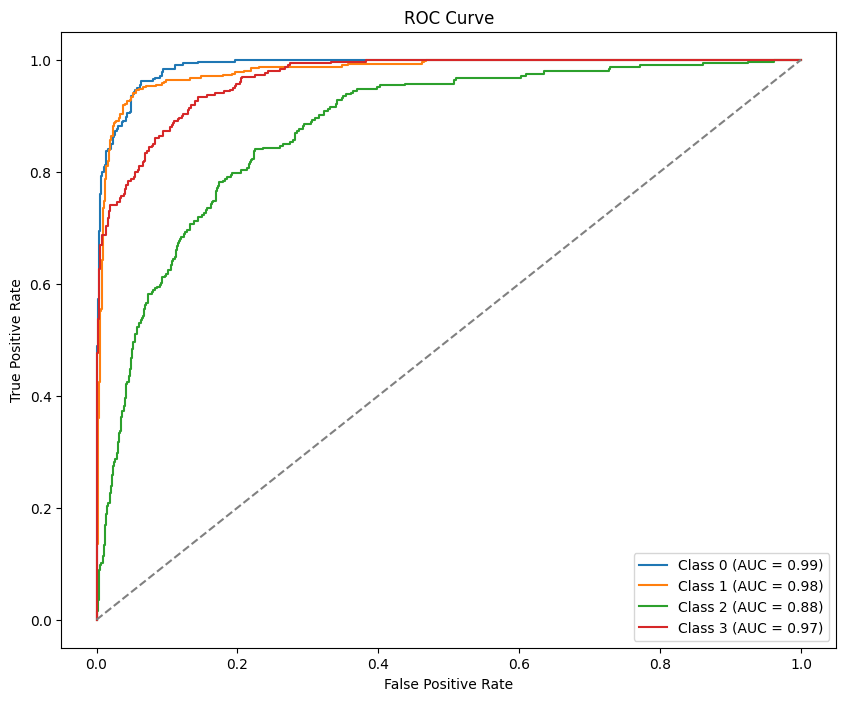

In [19]:
#roc curve
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions

fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [20]:
model.save('/content/drive/MyDrive/model.keras')

In [ ]:
model = load_model('/content/drive/MyDrive/model.keras')

In [24]:
#MRI Detection System
from keras.preprocessing.image import load_img, img_to_array
class_labels = ['pituitary', 'notumor', 'meningioma', 'glioma'] #order should be same as training model
def detect_and_display(image_path, model):
  try:
    img = load_img(image_path, target_size=(128,128))
    img_array = img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    confidence_score = np.max(predictions, axis=1)[0]
    if class_labels[predicted_class_index] == 'notumor':
      result = "No Tumor Detected"
    else:
      result = f"Tumor: {class_labels[predicted_class_index]}"

    plt.imshow(load_img(image_path))
    plt.axis('off')
    plt.title(f"{result} (Confidence:) {confidence_score*100:.2f}%")
    plt.show()

  except Exception as e:
    print("Error processing the image:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step


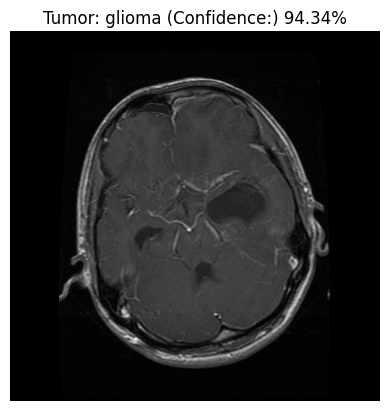

In [25]:
image_path = '/content/drive/MyDrive/dataset for BT ml/Testing/glioma/Te-glTr_0008.jpg'
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


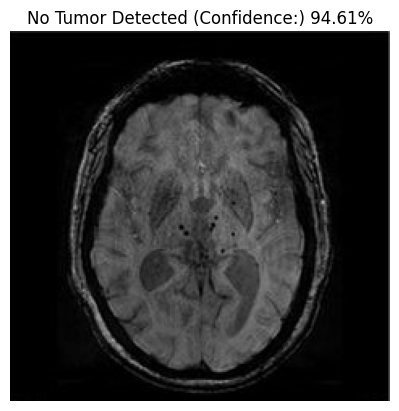

In [26]:
image_path = '/content/drive/MyDrive/dataset for BT ml/Testing/notumor/Te-no_0060.jpg'
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


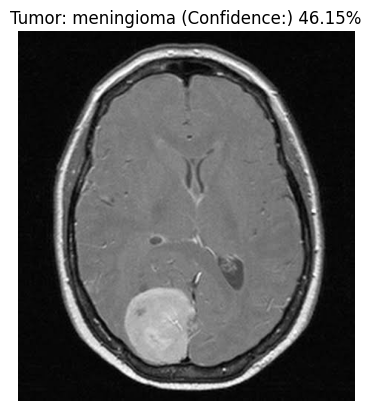

In [27]:
image_path = '/content/drive/MyDrive/dataset for BT ml/Testing/meningioma/Te-me_0010.jpg'
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


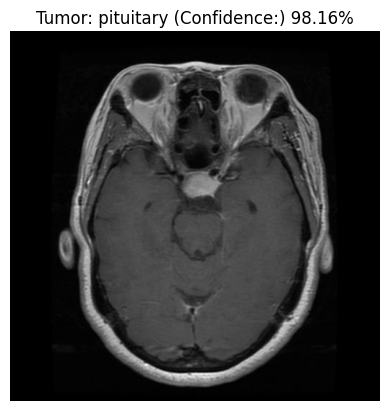

In [28]:
image_path = '/content/drive/MyDrive/dataset for BT ml/Testing/pituitary/Te-pi_0072.jpg'
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


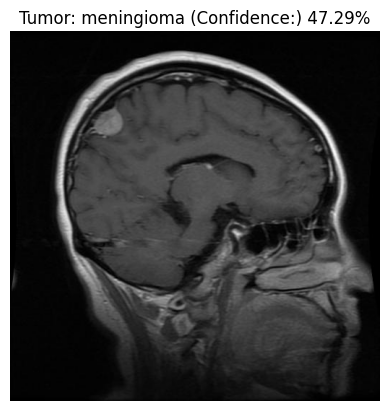

In [29]:
image_path = '/content/drive/MyDrive/dataset for BT ml/Testing/meningioma/Te-me_0271.jpg'
detect_and_display(image_path, model)

In [30]:
test_images = open_images(test_paths)
test_labels_encoded = encode_label(test_labels)
test_predictions = model.predict(test_images)

from sklearn.metrics import classification_report, accuracy_score

print("Test Accuracy:", accuracy_score(test_labels_encoded, np.argmax(test_predictions, axis=1)))
print("\nClassification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step
Test Accuracy: 0.8164652567975831

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.96      0.87       313
           1       0.92      0.90      0.91       405
           2       0.65      0.65      0.65       306
           3       0.92      0.71      0.80       300

    accuracy                           0.82      1324
   macro avg       0.82      0.81      0.81      1324
weighted avg       0.82      0.82      0.82      1324



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


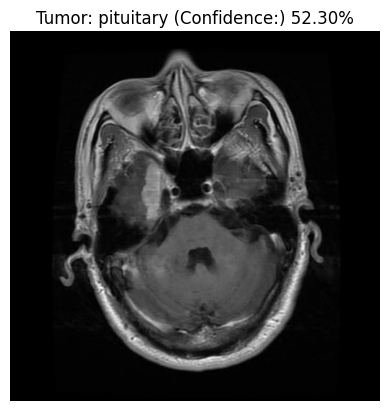

In [31]:
image_path = "/content/drive/MyDrive/dataset for BT ml/Testing/meningioma/Te-me_0115.jpg"
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


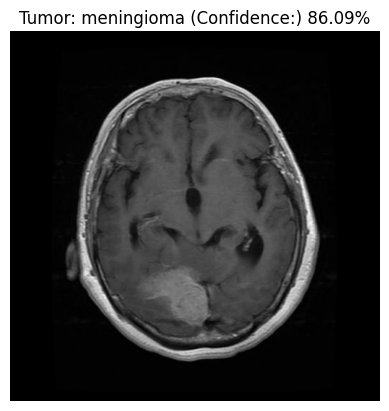

In [32]:
image_path = "/content/drive/MyDrive/dataset for BT ml/Testing/meningioma/Te-me_0295.jpg"
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


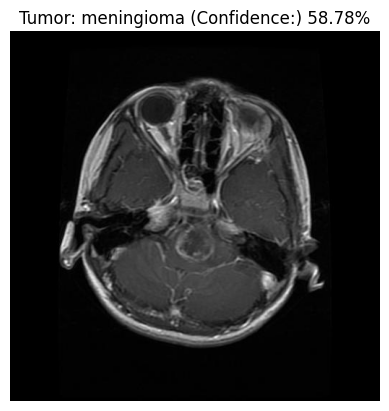

In [33]:
image_path = "/content/drive/MyDrive/dataset for BT ml/Testing/glioma/Te-gl_0091.jpg"
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


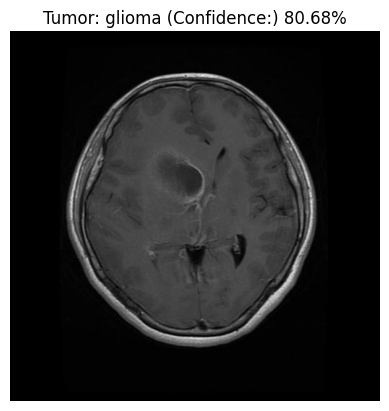

In [34]:
image_path = "/content/drive/MyDrive/dataset for BT ml/Testing/glioma/Te-gl_0292.jpg"
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


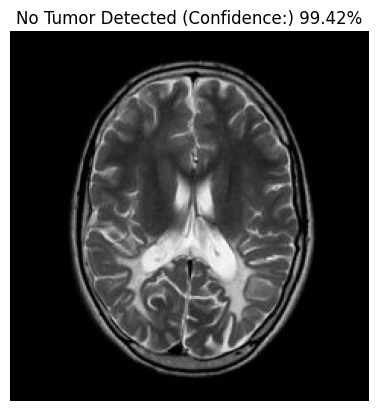

In [35]:
image_path = "/content/drive/MyDrive/dataset for BT ml/Testing/notumor/Te-no_0093.jpg"
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


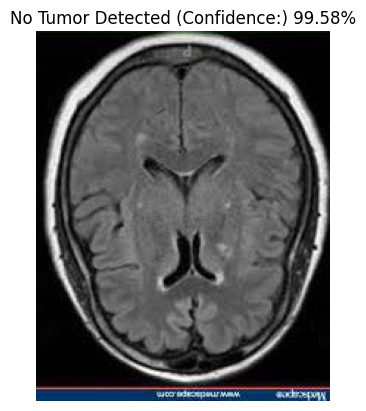

In [36]:
image_path = "/content/drive/MyDrive/dataset for BT ml/Testing/notumor/Te-no_0400.jpg"
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


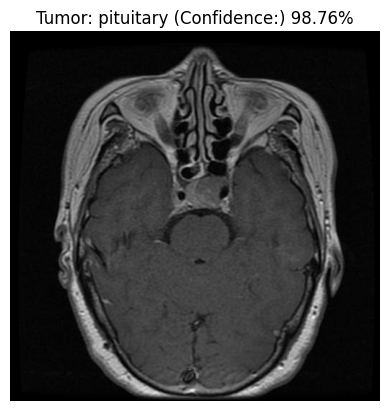

In [37]:
image_path = "/content/drive/MyDrive/dataset for BT ml/Testing/pituitary/Te-pi_0061.jpg"
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


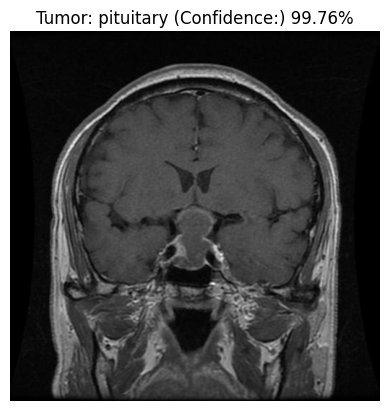

In [38]:
image_path = "/content/drive/MyDrive/dataset for BT ml/Testing/pituitary/Te-pi_0295.jpg"
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


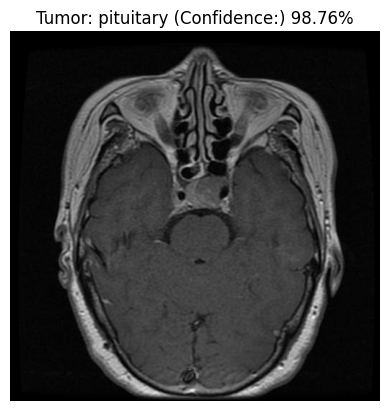

In [39]:
image_path = "/content/drive/MyDrive/dataset for BT ml/Testing/pituitary/Te-pi_0061.jpg"
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


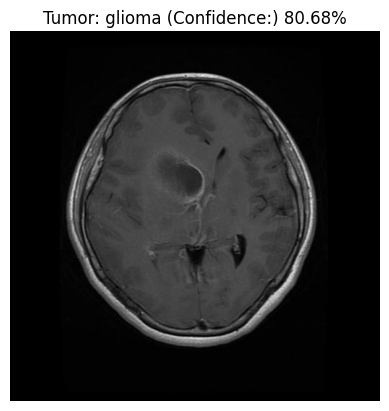

In [40]:
image_path = "/content/drive/MyDrive/dataset for BT ml/Testing/glioma/Te-gl_0292.jpg"
detect_and_display(image_path, model)

In [ ]:
from google.colab import files
files.download('/content/drive/MyDrive/model.keras')